# 01. NeMo Framework Single Node Pre-training

This notebook demonstrates how to train a GPT-style model with the NVIDIA NeMo Framework.

The total training will take a considerable amount of time, but can be achieved on a GPU with as low as 16GB of GPU RAM.

In [1]:
import torch
use_cuda = torch.cuda.is_available()

if not use_cuda:
    exit()

print(torch.cuda.get_device_name(0))
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__CUDA Device Name:',torch.cuda.get_device_name(0))
print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)
print('Memory Usage:')
print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

NVIDIA A40-16Q
__CUDNN VERSION: 8907
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA A40-16Q
__CUDA Device Total Memory [GB]: 16.966156288
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
!nvidia-smi

Mon May 20 20:58:28 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A40-16Q                 On  |   00000000:03:00.0 Off |                    0 |
| N/A   N/A    P8             N/A /  N/A  |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Prepare dataset and dataloader

Get tokenizer files
This step uses This playbook demonstrates how to train a GPT-style model with the NVIDIA NeMo Framework.

The total training will take a considerable amount of time, but can be achieved on a GPU with as low as 16GB of GPU RAM.

In [3]:
!wget https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-vocab.json
!wget https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-merges.txt

--2024-05-20 20:58:35--  https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-vocab.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.122.144, 54.231.135.240, 52.217.48.126, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.122.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1042301 (1018K) [application/json]
Saving to: ‘gpt2-vocab.json.1’

gpt2-vocab.json.1   100%[===================>]   1018K  --.-KB/s    in 0.1s    

2024-05-20 20:58:36 (7.92 MB/s) - ‘gpt2-vocab.json.1’ saved [1042301/1042301]

--2024-05-20 20:58:36--  https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-merges.txt
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.36.152, 52.217.122.144, 54.231.135.240, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.36.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 456318 (446K) [text/plain]
Saving to: ‘gpt2-merges.txt.1’

gpt2-merges.txt.1   100%[===================>] 445.

In this example, we use dataset used in [official LoRA example](https://github.com/microsoft/LoRA).

Download dataset from official repository.

In [5]:
!wget https://huggingface.co/datasets/databricks/databricks-dolly-15k/resolve/main/databricks-dolly-15k.jsonl

--2024-05-20 20:29:22--  https://huggingface.co/datasets/databricks/databricks-dolly-15k/resolve/main/databricks-dolly-15k.jsonl
Resolving huggingface.co (huggingface.co)... 18.172.134.88, 18.172.134.4, 18.172.134.124, ...
Connecting to huggingface.co (huggingface.co)|18.172.134.88|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/34/ac/34ac588cc580830664f592597bb6d19d61639eca33dc2d6bb0b6d833f7bfd552/2df9083338b4abd6bceb5635764dab5d833b393b55759dffb0959b6fcbf794ec?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27databricks-dolly-15k.jsonl%3B+filename%3D%22databricks-dolly-15k.jsonl%22%3B&Expires=1716496162&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxNjQ5NjE2Mn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy8zNC9hYy8zNGFjNTg4Y2M1ODA4MzA2NjRmNTkyNTk3YmI2ZDE5ZDYxNjM5ZWNhMzNkYzJkNmJiMGI2ZDgzM2Y3YmZkNTUyLzJkZjkwODMzMzhiNGFiZDZiY2ViNTYzNTc2NGRh

Step 4: Convert training data into memory map format

The memory map format makes training more efficient, especially with many nodes and GPUs. This step will also tokenize data using the tokenizer model from Step 3.

In [4]:
!python /opt/NeMo/scripts/nlp_language_modeling/preprocess_data_for_megatron.py \
--input=databricks-dolly-15k.jsonl \
--json-keys=context \
--tokenizer-library=megatron \
--vocab gpt2-vocab.json \
--dataset-impl mmap \
--tokenizer-type GPT2BPETokenizer \
--merge-file gpt2-merges.txt \
--output-prefix=hfbpe_gpt_training_data \
--append-eod \
--workers=32

[NeMo I 2024-05-20 20:59:14 tokenizer_utils:198] Getting Megatron tokenizer for pretrained model name: megatron-gpt-345m, custom vocab file: gpt2-vocab.json, and merges file: gpt2-merges.txt
[NeMo I 2024-05-20 20:59:14 tokenizer_utils:127] Getting HuggingFace AutoTokenizer with pretrained_model_name: gpt2, vocab_file: gpt2-vocab.json, merges_files: gpt2-merges.txt, special_tokens_dict: {}, and use_fast: False
Vocab size: 50257
Output prefix: hfbpe_gpt_training_data
Time to startup: 0.2828195095062256
[NeMo I 2024-05-20 20:59:15 tokenizer_utils:198] Getting Megatron tokenizer for pretrained model name: megatron-gpt-345m, custom vocab file: gpt2-vocab.json, and merges file: gpt2-merges.txt
[NeMo I 2024-05-20 20:59:15 tokenizer_utils:127] Getting HuggingFace AutoTokenizer with pretrained_model_name: gpt2, vocab_file: gpt2-vocab.json, merges_files: gpt2-merges.txt, special_tokens_dict: {}, and use_fast: False
[NeMo I 2024-05-20 20:59:15 tokenizer_utils:198] Getting Megatron tokenizer for p

Train GPT-style model
Once you have prepared the training data and tokenizer, you are ready to train the model.

The following configuration has about 124M parameters and should fit on a single 16GB GPU using float16.

In [ ]:
!python /opt/NeMo/examples/nlp/language_modeling/megatron_gpt_pretraining.py  \
    --config-path=conf/ \
    --config-name=megatron_gpt_config \
    trainer.devices=1 \
    trainer.num_nodes=1 \
    trainer.max_epochs=null \
    trainer.max_steps=300000 \
    trainer.val_check_interval=300 \
    trainer.log_every_n_steps=50 \
    trainer.limit_val_batches=50 \
    trainer.limit_test_batches=50 \
    trainer.accumulate_grad_batches=1 \
    trainer.precision=16 \
    model.micro_batch_size=6 \
    model.global_batch_size=192 \
    model.tensor_model_parallel_size=1 \
    model.pipeline_model_parallel_size=1 \
    model.max_position_embeddings=1024 \
    model.encoder_seq_length=1024 \
    model.hidden_size=768 \
    model.ffn_hidden_size=3072 \
    model.num_layers=12 \
    model.num_attention_heads=12 \
    model.init_method_std=0.021 \
    model.hidden_dropout=0.1 \
    model.layernorm_epsilon=1e-5 \
    model.tokenizer.vocab_file=gpt2-vocab.json \
    model.tokenizer.merge_file=gpt2-merges.txt \
    model.data.data_prefix=[1.0,hfbpe_gpt_training_data_context_document] \
    model.data.num_workers=2 \
    model.data.seq_length=1024 \
    model.data.splits_string=\'980,10,10\' \
    model.optim.name=fused_adam \
    model.optim.lr=6e-4 \
    model.optim.betas=[0.9,0.95] \
    model.optim.weight_decay=0.1 \
    model.optim.sched.name=CosineAnnealing \
    model.optim.sched.warmup_steps=750 \
    model.optim.sched.constant_steps=80000 \
    model.optim.sched.min_lr=6e-5 \
    exp_manager.resume_if_exists=True \
    exp_manager.resume_ignore_no_checkpoint=True \
    exp_manager.create_checkpoint_callback=True \
    exp_manager.checkpoint_callback_params.monitor=val_loss \
    exp_manager.checkpoint_callback_params.save_top_k=3 \
    exp_manager.checkpoint_callback_params.mode=min \
    exp_manager.checkpoint_callback_params.always_save_nemo=False

[NeMo W 2024-05-20 21:00:09 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/hydra/_internal/hydra.py:119: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
    See https://hydra.cc/docs/next/upgrades/1.1_to_1.2/changes_to_job_working_dir/ for more information.
      ret = run_job(
    
[NeMo I 2024-05-20 21:00:09 megatron_gpt_pretraining:34] 
    
    ************** Experiment configuration ***********
[NeMo I 2024-05-20 21:00:09 megatron_gpt_pretraining:35] 
    name: megatron_gpt
    restore_from_path: null
    trainer:
      devices: 1
      num_nodes: 1
      accelerator: gpu
      precision: 16
      logger: false
      enable_checkpointing: false
      use_distributed_sampler: false
      max_epochs: null
      max_steps: 300000
      log_every_n_steps: 50
      val_check_interval: 300
      limit_val_batches: 50
      limit_test_batches: 50
      accumulate_grad_batches: 1
      gradient_clip_val: 1.0
      benchmark:

Show loss transition in plot.

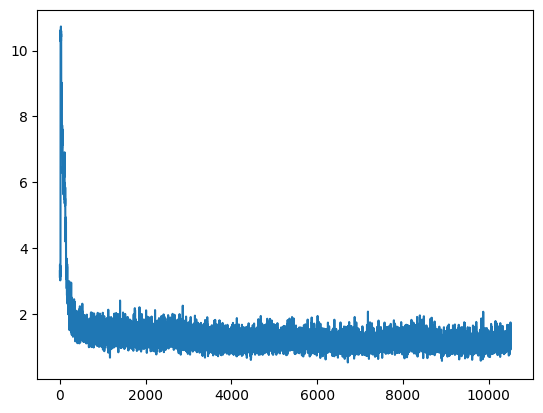

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv("loss.txt")
plt.plot(data)
plt.show()

## Generate text with fine-tuned model

Again we check results with our test dataset (5 rows).<br>
As you can see below, it can output the completion very well, because it's fine-tuned.